# Supplementary information

This notebook provides supplementary information for the manuscript: "???"


# imports and custom functions

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
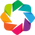

In [95]:
import numpy as np
import pandas as pd
import holoviews as hv
hv.extension('bokeh')
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic_2d
from tqdm import tqdm
import yaml
import xarray as xr
import hvplot.xarray
import urllib.request
import panel.widgets as pnw

In [96]:
from holoviews import opts
opts.defaults(
    opts.Scatter(width=1200, height=400, tools=["hover"], show_grid=True, size=8),
    opts.Histogram(width=1000, height=400, tools=["hover"], ),
    opts.Image(frame_width=400, frame_height=400, tools=["hover"], xlabel="ToT1 (ns)", ylabel="ToT2 (ns)", fontscale=1.5),
    opts.Curve(width=1200, height=500, tools=["hover"], show_grid=True, fontscale=1.5),
    opts.Points(width=1000, height=500, tools=["hover"], show_grid=True)
)

## custom functions

In [97]:
offset = -28
def fit_single_scan(scan_nr: str) -> list:
    global df_scans
    model = lambda t, A, B, c: A * (1 - B * np.exp(-t / c))
    loss = lambda t, A, B, c: model(t, A, B, c)[0] / A

    # define our x-axis from the first scans
    x_axe = np.float_(runNrs["scan0100"]["delays"]) - 1

    # fetch data
    df = df_scans.query(f"`scan name` == '{scan_nr}'")

    # omit nans
    y = df[~df['ToT2 (ns)'].isna()]['ToT2 (ns)']
    if len(y) > -offset:
        y = y[offset:]
    x = x_axe[-len(y):]
    # unequal starting for fit
    #y = y[4:]
    #x = x_axe[-(len(y)):]
    #assert len(y) == len(x)

    p0 = [y[-6:].mean(), 1, 8]
    popt, _ = curve_fit(
        model,
        x, y,
        p0=p0,
        maxfev=5000,
        bounds=((50, 1e-2, 1), (2150, 1, 15)),
    )

    return [
        popt[2],  # recovery time
        df['ToT1 (ns)'][-6:].mean(),  # mean ToT1
        y[-6:].mean(),  # mean ToT2
        (popt[0] - model(np.array([2]), *popt))[0],  # absolute loss 2 µs
        (popt[0] - model(np.array([3]), *popt))[0],  # absolute loss 3 µs
        (popt[0] - model(np.array([4]), *popt))[0],  # absolute loss 4 µs
        (1 - loss(np.array([2]), *popt)) * 100,  # relative loss 2 µs
        (1 - loss(np.array([3]), *popt)) * 100,  # relative loss 3 µs
        (1 - loss(np.array([4]), *popt)) * 100,  # relative loss 4 µs
        (1 - loss(np.array([5]), *popt)) * 100,
        (1 - loss(np.array([6]), *popt)) * 100,
        (1 - loss(np.array([7]), *popt)) * 100,
        (1 - loss(np.array([8]), *popt)) * 100,
        (1 - loss(np.array([9]), *popt)) * 100,
        (1 - loss(np.array([10]), *popt)) * 100,
    ]

In [98]:
get_x_axis_from_bins = lambda x_bins: 0.5 * (x_bins[1:] + x_bins[:-1])

# load data

In [99]:
with urllib.request.urlopen("https://syncandshare.desy.de/index.php/s/zgPcWZMyBGcQ5MC/download/TOT_scans.yaml") as f:
    runNrs = yaml.safe_load(f)

In [100]:
tot1s = set([i['tot1'] for i in runNrs.values()])
tot2s = set([i['tot2'] for i in runNrs.values()])

#scan_data = pd.read_parquet('https://syncandshare.desy.de/index.php/s/KRA42M7YimM3PAP/download/scan_data.parq')
scan_data = pd.read_parquet('data/scan_data.parq')
scan_data

In [101]:
df_scans = pd.read_parquet('https://syncandshare.desy.de/index.php/s/Dw3Nf2PQ59QppYH/download/df_scans.parq')
#df_scans = pd.read_parquet('data/df_scans.parq')

## convert single traces to matrix

In [102]:
tot1_tot2 = []
for scan in tqdm(runNrs.keys()):
    tot1_tot2.append((*fit_single_scan(scan), scan))

tot1_tot2 = pd.DataFrame(
    tot1_tot2,
    columns=[
        "recovery",
        "ToT1",
        "ToT2",
        "absolute loss 2µs",
        "absolute loss 3µs",
        "absolute loss 4µs",
        "relativ loss 2µs",
        "relativ loss 3µs",
        "relativ loss 4µs",
        "relativ loss 5µs",
        "relativ loss 6µs",
        "relativ loss 7µs",
        "relativ loss 8µs",
        "relativ loss 9µs",
        "relativ loss 10µs",
        "scan",
    ],
)
tot1_tot2["ToT1 / ToT2"] = tot1_tot2["ToT1"] / tot1_tot2["ToT2"]
tot1_tot2["ToT2 / ToT1"] = tot1_tot2["ToT2"] / tot1_tot2["ToT1"]
tot1_tot2

100%|██████████| 412/412 [00:01<00:00, 353.71it/s]


,recovery,ToT1,ToT2,absolute loss 2µs,absolute loss 3µs,absolute loss 4µs,relativ loss 2µs,relativ loss 3µs,relativ loss 4µs,relativ loss 5µs,relativ loss 6µs,relativ loss 7µs,relativ loss 8µs,relativ loss 9µs,relativ loss 10µs,scan,ToT1 / ToT2,ToT2 / ToT1
0,8.541351,110.218292,95.838674,5.779494,5.140954,4.572962,6.045242,5.377341,4.783232,4.254763,3.784681,3.366535,2.994588,2.663734,2.369435,scan0100,1.150040,0.869535
1,10.946572,109.101351,184.368724,5.544392,5.060342,4.618553,3.004662,2.742342,2.502924,2.284408,2.084969,1.902942,1.736807,1.585176,1.446783,scan0101,0.591756,1.689885
2,6.811040,110.070967,275.348234,5.135962,4.434641,3.829087,1.863216,1.608792,1.389110,1.199425,1.035643,0.894225,0.772117,0.666684,0.575648,scan0102,0.399752,2.501552
3,6.045174,110.373419,366.552883,4.658601,3.948335,3.346359,1.269682,1.076102,0.912036,0.772984,0.655132,0.555249,0.470594,0.398845,0.338036,scan0103,0.301112,3.321025
4,5.673082,109.339787,456.059330,3.203747,2.685992,2.251911,0.702899,0.589304,0.494067,0.414221,0.347279,0.291156,0.244102,0.204653,0.171579,scan0104,0.239749,4.171028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,7.800385,1979.918792,1598.531834,329.641433,289.978476,255.087826,20.621760,18.140519,15.957824,14.037755,12.348711,10.862895,9.555855,8.406080,7.394648,scan0507,1.238586,0.807372
408,7.844471,1981.671597,1698.670732,343.756835,302.613436,266.394389,20.231601,17.810131,15.678481,13.801963,12.150040,10.695832,9.415675,8.288736,7.296678,scan0508,1.166601,0.857191
409,7.925330,1983.302672,1802.637679,361.127178,318.318506,280.584452,20.032525,17.657833,15.564641,13.719580,12.093236,10.659682,9.396064,8.282238,7.300446,scan0509,1.100223,0.908907
410,7.974022,1982.324999,1899.832321,376.690342,332.292711,293.127891,19.825650,17.488951,15.427661,13.609320,12.005293,10.590320,9.342119,8.241035,7.269727,scan0510,1.043421,0.958386


# Plots
## Single trace

- yellow mostly straigt line: ToT1
- blue dots: values for ToT2
- green curve of the dots
- vertical blue line: average ToT1 of first 6 values + 475 ns

In [103]:
def load_tot_curves(tot1, tot2, **kwargs):
    global df_scans
    # define our x-axis from the first scans
    x_axe = np.float_(runNrs["scan0100"]["delays"]) - 1
    model = lambda tau, A, B, c: A * (1 - B * np.exp(-tau / c))

    # get scan_nr for ToT combination
    scan_nr = [k for k, v in runNrs.items() if v['tot1'] == tot1 and v['tot2'] == tot2]
    
    # for few ToT combinations, there are multiple scans; just take the first one
    if len(scan_nr) > 0:
        scan_nr = scan_nr[0]
    else:
        scan_nr = 'scan0278'
    df = df_scans.query(f'`scan name` == "{scan_nr}"')

    # omit nans
    y = df[~df['ToT2 (ns)'].isna()]['ToT2 (ns)']
    if len(y) > -offset:
        y = y[offset:]
    x = x_axe[-len(y):]
    p0 = [df['ToT2 (ns)'][-6:].mean(), 1, 1]
    try:
        popt, _ = curve_fit(model, x, y, p0=p0)
    except:
        popt = p0

    return hv.Overlay(
            hv.Curve((x_axe, df['ToT2 (ns)']), label='ToT of 2nd LED') *
            hv.Scatter((x_axe, df['ToT2 (ns)']), label='ToT of 2nd LED').opts(size=5) *
            hv.Curve(
                (x, model(x, *popt)),
                label=f"A(1-B exp(-t/c)): A={popt[0]:.1f}, B={popt[1]:.2f}, c={popt[2]:.2f}",).opts(color='green') *
            hv.ErrorBars(np.column_stack([x_axe, df['ToT2 (ns)'], df['ToT2 error']])) #*
            * hv.Curve((x_axe, df['ToT1 (ns)']), label=f"ToT of 1st LED") 
            * hv.VLine((df['ToT1 (ns)'][:5].mean()+475)*1e-3)
            ).opts(legend_position="bottom_right", framewise=True).opts(
                opts.Curve(
                xlabel="delay (µs)",
                ylabel="mean ToT (ns)",
                title=f'{scan_nr}, IKrum={runNrs[scan_nr]["IKrum"]}',
                xlim=(0.5, None),
                logx=True,
                framewise=True
        )).opts(legend_position="right")

dmap = hv.DynamicMap(load_tot_curves, kdims=['ToT1','ToT2'])
dmap = dmap.redim.values(ToT1=tot1s, ToT2=tot2s)

dmap.opts(framewise=True)

BokehModel(combine_events=True, render_bundle={'docs_json': {'7f4b8ab5-823c-4b8e-b4ed-35768462a67f': {'version…

## Recovery time

In [104]:
xy_hist, x_bins, y_bins, binnumber = binned_statistic_2d(tot1_tot2['ToT1'], tot1_tot2['ToT2'], 
    tot1_tot2.recovery, bins=(range(50, 2150, 100), range(50, 2150, 100)))
a = hv.Image(xy_hist.T[::-1], bounds=[x_bins[0], y_bins[0], x_bins[-1], y_bins[-1]])
a.opts(cmap='coolwarm', logz=True, colorbar=True)

x_hist, x_bins = np.histogram(tot1_tot2.recovery, bins=20)
x = get_x_axis_from_bins(x_bins) 
b = hv.Curve((x, x_hist))
c = hv.Scatter((x, x_hist))
b.opts(width=400, xlabel='Recovery time (µs)', ylabel='counts')

(a + b * c).opts(shared_axes=False)

:Layout
   .Image.I   :Image   [x,y]   (z)
   .Overlay.I :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Scatter.I :Scatter   [x]   (y)

## absolute loss

In [105]:
x_bins, y_bins = np.arange(50, 2150, 100), np.arange(50, 2150, 100)
x = get_x_axis_from_bins(x_bins)
y = get_x_axis_from_bins(y_bins)
data = []
dims = []
gen = (col for col in tot1_tot2.columns if col.startswith("absolute"))
for col in gen:
    data.append(
        binned_statistic_2d(
            tot1_tot2["ToT1"],
            tot1_tot2["ToT2"],
            tot1_tot2[col],
            bins=(x_bins, y_bins),
        )[0].T
    )
    dims.append(col)
data = np.array(data)
da = xr.DataArray(data, coords=[("Δt", dims), ("ToT1", x), ("ToT2", y)])

In [106]:
da.hvplot(groupby='Δt', cmap='viridis')

BokehModel(combine_events=True, render_bundle={'docs_json': {'8278f82a-1b59-4247-9376-f71d58cc8ccd': {'version…

## relativ loss

In [107]:
x_bins, y_bins = np.arange(50, 2150, 100), np.arange(50, 2150, 100)
x = get_x_axis_from_bins(x_bins)
y = get_x_axis_from_bins(y_bins)
data = []
dims = []
gen = (col for col in tot1_tot2.columns if col.startswith("relativ"))
for col in gen:
    data.append(
        binned_statistic_2d(
            tot1_tot2["ToT1"],
            tot1_tot2["ToT2"],
            tot1_tot2[col],
            bins=(x_bins, y_bins),
        )[0].T
    )
    dims.append(col)
data = np.array(data)
da = xr.DataArray(data, coords=[("Δt", dims), ("ToT1", x), ("ToT2", y)])

In [108]:
da.hvplot(groupby='Δt', cmap='viridis')

BokehModel(combine_events=True, render_bundle={'docs_json': {'dae166ed-f825-4d40-9420-503f274ed4ba': {'version…

# model

## step 0

In [109]:
xy_hist, x_bins, y_bins, binnumber = binned_statistic_2d(tot1_tot2['ToT1'], tot1_tot2['ToT2'], 
    #tot1_tot2['relativ loss 2µs'], bins=(range(50, 2150, 100), range(50, 2150, 100)))
    tot1_tot2['relativ loss 3µs'], bins=(range(50, 2150, 100), range(50, 2150, 100)))
x = get_x_axis_from_bins(x_bins)
y = get_x_axis_from_bins(y_bins)

In [110]:
hv.Overlay(
    hv.Curve((x, xy_hist[:, 14]), label=f"ToT2={y_bins[14]+50}") *
    hv.Curve((x, xy_hist[:, 9]), label=f"ToT2={y_bins[9]+50}") *
	hv.Curve((x, xy_hist[:, 4]), label=f"ToT2={y_bins[4]+50}") *
	hv.Curve((x, xy_hist[:, 1]), label=f"ToT2={y_bins[1]+50}") *
	hv.Curve((x, xy_hist[:, 0]), label=f"ToT2={y_bins[0]+50}") 
).opts(legend_position='top_left').opts(
    opts.Curve(xlabel='ToT1 (ns)', ylabel='relativ loss')
)
#plt.xlabel('ToT1 (ns)')$ *
#plt.ylabel('relativ loss')

:Overlay
   .Curve.ToT2_equals_1500_full_stop_0 :Curve   [x]   (y)
   .Curve.ToT2_equals_1000_full_stop_0 :Curve   [x]   (y)
   .Curve.ToT2_equals_500_full_stop_0  :Curve   [x]   (y)
   .Curve.ToT2_equals_200_full_stop_0  :Curve   [x]   (y)
   .Curve.ToT2_equals_100_full_stop_0  :Curve   [x]   (y)

## step 1
take the TOT2(TOT1) for every Δt the relative loss is calculated for and fit the slope from a linear function

In [111]:
plots = []
params = []
for Δt in tqdm(range(2, 11)):
    xy_hist, x_bins, y_bins, binnumber = binned_statistic_2d(tot1_tot2['ToT1'], tot1_tot2['ToT2'], 
                                                             tot1_tot2[f'relativ loss {Δt}µs'], bins=(range(50, 2150, 100), range(50, 2150, 100)))
    ToT1 = x = get_x_axis_from_bins(x_bins)
    y = get_x_axis_from_bins(y_bins)

    for loss, ToT2 in zip(xy_hist.T, x):
        model1 = lambda ToT1, m: m * ToT1
        
        mask = ~np.isnan(loss)
        if mask.any() == True:
            popt1, _ = curve_fit(model1, ToT1[mask], loss[mask])
            params.append([Δt, ToT2, *popt1])

            plots.append(hv.Curve((ToT1, loss), label=f'Δt = {Δt} µs, ToT2 = {ToT2:n}').opts(xlabel='ToT1 (ns)', ylabel="loss (%)", width=400) * 
                         hv.Curve((ToT1, model1(ToT1, *popt1)), label=', '.join([f'{i:.2e}' for i in popt1])) #*
                         #hv.Curve((ToT2, model2(ToT2, *popt2)), label=', '.join([f'{i:.2f}' for i in popt2]))
                        )
params_ToT2 = pd.DataFrame(params, columns=['Δt', 'ToT2', 'm',])


100%|██████████| 9/9 [00:00<00:00, 22.84it/s]


# step 2
fit an exponetial decay for every TOT2 for the Δt

In [112]:
model = lambda x, A, c: A * np.exp(- x / c)

plots = []
params_expfit = []
for key, df in params_ToT2.groupby("ToT2")['Δt', 'm']:
    popt, _ = curve_fit(model, df['Δt'], df['m'])
    params_expfit.append([key, *popt])
    
    plots.append(hv.Curve(  (df['Δt'], df['m']), label=f'ToT2 = {key}').opts(xlabel='Δt (ns)', ylabel='slope') *
                 hv.Scatter((df['Δt'], df['m']), label=f'ToT2 = {key}').opts(size=5)
                )

params_expfit = pd.DataFrame(params_expfit, columns=['ToT2', 'A', 'c'])
hv.Overlay(plots[::2]).opts(legend_position='left', fontscale=1.5)

/var/folders/cs/c4lgxx9j45x3bkbb8590h85r0000gp/T/ipykernel_40179/3666404399.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  for key, df in params_ToT2.groupby("ToT2")['Δt', 'm']:


:Overlay
   .Curve.ToT2_equals_100_full_stop_0    :Curve   [x]   (y)
   .Scatter.ToT2_equals_100_full_stop_0  :Scatter   [x]   (y)
   .Curve.ToT2_equals_300_full_stop_0    :Curve   [x]   (y)
   .Scatter.ToT2_equals_300_full_stop_0  :Scatter   [x]   (y)
   .Curve.ToT2_equals_500_full_stop_0    :Curve   [x]   (y)
   .Scatter.ToT2_equals_500_full_stop_0  :Scatter   [x]   (y)
   .Curve.ToT2_equals_700_full_stop_0    :Curve   [x]   (y)
   .Scatter.ToT2_equals_700_full_stop_0  :Scatter   [x]   (y)
   .Curve.ToT2_equals_900_full_stop_0    :Curve   [x]   (y)
   .Scatter.ToT2_equals_900_full_stop_0  :Scatter   [x]   (y)
   .Curve.ToT2_equals_1100_full_stop_0   :Curve   [x]   (y)
   .Scatter.ToT2_equals_1100_full_stop_0 :Scatter   [x]   (y)
   .Curve.ToT2_equals_1300_full_stop_0   :Curve   [x]   (y)
   .Scatter.ToT2_equals_1300_full_stop_0 :Scatter   [x]   (y)
   .Curve.ToT2_equals_1500_full_stop_0   :Curve   [x]   (y)
   .Scatter.ToT2_equals_1500_full_stop_0 :Scatter   [x]   (y)
   .Curve.ToT2_equals_1700_full_stop_0   :Curve   [x]   (y)
   .Scatter.ToT2_equals_1700_full_stop_0 :Scatter   [x]   (y)
   .Curve.ToT2_equals_1900_full_stop_0   :Curve   [x]   (y)
   .Scatter.ToT2_equals_1900_full_stop_0 :Scatter   [x]   (y)

## step 3
fit the model $\frac{d}{ToT + B}+g$ from the previously extracted fit parameter $A$

In [113]:
model = lambda ToT, d, B, g: d / (ToT + B) + g
popt, _ = curve_fit(model, params_expfit['ToT2'][1:], params_expfit['A'][1:], p0=[6, 39, 8e-3])
x_axe = range(200, 2000)

a = hv.Curve((params_expfit['ToT2'], params_expfit['c']), label=f'fit parameter c: median={params_expfit["c"].median():.3f}')
b = (hv.Curve((params_expfit['ToT2'], params_expfit['A']), label=f'fit parameter A').opts(xlabel='ToT2 (ns)', fontscale=1.5) *
     hv.Scatter((params_expfit['ToT2'], params_expfit['A']), label=f'fit parameter A').opts(size=5) *
     hv.Curve((x_axe, model(x_axe, *popt)), label=', '.join([f'{i:.2e}' for i in popt])))

#hv.Layout(a + b).opts(shared_axes=False)
b

:Overlay
   .Curve.Fit_parameter_A                                                                                            :Curve   [x]   (y)
   .Scatter.Fit_parameter_A                                                                                          :Scatter   [x]   (y)
   .Curve.A_1_full_stop_90e_plus_00_comma_hyphen_minus_1_full_stop_36e_plus_02_comma_1_full_stop_12e_hyphen_minus_02 :Curve   [x]   (y)

## step 4
all parameters are together for the model
$$
ToT_1 \exp(-t / c) \left(\frac{d}{ToT_2 + B} + g\right)
$$

In [114]:
print(f'c = {params_expfit["c"][2:].median():2f}')
print(f'd = {popt[0]:.2f}')
print(f'B = {popt[1]:.1f}')
print(f'g = {popt[2]:.3f}')

c = 8.030214
d = 1.90
B = -135.7
g = 0.011


In [133]:
d = popt[0]
B = popt[1]
g = popt[2]
c = params_expfit["c"].median()
t = 2
model = lambda ToT1, ToT2, t, d, g, B: ToT1 * np.exp(-t / c) * (d / (ToT2 + B) + g)


ToT1 = list(range(100, 2050, 100))
ToT2 = list(range(200, 2050, 100))
H_model = np.array([model(i, ToT2, t, d, g, B) for i in ToT1]).T[::-1]
#a = hv.Image(H_model, bounds=[ToT1[0]-50, ToT2[0]-50, ToT1[-1]+50, ToT2[-1]+50], label=f'model: {t} µs').opts(xlabel="ToT1 (ns)", ylabel="ToT2 (ns)")

xy_exp, x_bins, y_bins, binnumber = binned_statistic_2d(tot1_tot2['ToT1'], tot1_tot2['ToT2'], 
    tot1_tot2[f'relativ loss {t}µs'], bins=(range(50, 2150, 100), range(150, 2150, 100)))
H_exp = xy_exp.T[::-1]

H_diff = H_exp - H_model
#c = hv.Image(H_diff,
#    bounds=(x_bins[0], y_bins[0], x_bins[-1], y_bins[-1])).opts(title=f"differenence (%)at {t}µs", cmap='coolwarm', shared_axes=False)

print(f"min. difference: {np.nanmin(H_diff):.2f}, max. difference: {np.nanmax(H_diff):.2f}")
#(a + b + c).opts(opts.Image(xlabel='ToT1 (ns)', ylabel='ToT2 (ns)', cmap='jet', colorbar=True, clim=(0, 65), fontscale=1.5))

min. difference: -3.43, max. difference: 3.56


In [135]:
ToT2[0]

200

In [136]:
axis_lim = [ToT1[0]-50, ToT2[0]-50, ToT1[-1]+50, ToT1[-1]+50]
hv.Layout(hv.Image(H_model, bounds=axis_lim).opts(title='model', cmap="viridis") + 
          hv.Image(H_exp, bounds=axis_lim).opts(title='experiment', cmap="viridis") + 
          hv.Image(H_diff, bounds=axis_lim).opts(title='Δ(model, experiment)', cmap="coolwarm")
          ).opts(
              opts.Image(colorbar=True, axiswise=True)
          )

:Layout
   .Image.I   :Image   [x,y]   (z)
   .Image.II  :Image   [x,y]   (z)
   .Image.III :Image   [x,y]   (z)